### Step 0: Activate the GPU

In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device is not found')
print("Found GPU at: {}".format(device_name))

Found GPU at: /device:GPU:0


### Step 1: Installing the Hugging Face PyTorch interface for BERT

Hugging Face provides a pretrained BERT model. Hugging Face developed a base
class named `PreTrainedModel`. By installing this class, we can load a model from a
pretrained model configuration.

In [ ]:
! pip -qq install transformers

### Step 3: Importing the modules

In [ ]:
import torch
from torch.utils.data import DataLoader, RandomSampler, TensorDataset, SequentialSampler

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

from transformers import BertTokenizer, BertConfig, BertModel
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup

from tqdm import tqdm, trange

import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt

### Step 4: Specifying CUDA as the device for torch

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
n_gpu = torch.cuda.device_count()
print(f"The name of the CUDA gpu is: {torch.cuda.get_device_name(0)}, The number of gpu devices: {n_gpu}")

The name of the CUDA gpu is: Tesla T4, The number of gpu devices: 1


### Step 5: Upload `in_domain_train.tsv` and `out_of_domain_dev.tsv`, which you will find in `tiasaxena/Documents/code/data_for_ML-DL`. Next, load the dataset.

Source of dataset : https://nyu-mll.github.io/CoLA/

* Column 1: the source of the sentence (code)
* Column 2:	the acceptability judgment label (0=gramatically unacceptable, 1= gramatically acceptable).
* Column 3:	the acceptability judgment as originally notated by the author.
* Column 4: the sentence to be classified

In [ ]:
df = pd.read_csv("in_domain_train.tsv", delimiter="\t", header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

print(f"Shape of the Dataframe: {df.shape}")
df.head(n=100)

Shape of the Dataframe: (8551, 4)


,sentence_source,label,label_notes,sentence
0,gj04,1,NaN,"our friends wo n't buy this analysis , let alo..."
1,gj04,1,NaN,one more pseudo generalization and i 'm giving...
2,gj04,1,NaN,one more pseudo generalization or i 'm giving ...
3,gj04,1,NaN,"the more we study verbs , the crazier they get ."
4,gj04,1,NaN,day by day the facts are getting murkier .
...,...,...,...,...
95,gj04,0,*,the ball wriggled itself loose .
96,gj04,1,NaN,bill wriggled himself loose .
97,gj04,1,NaN,aliza wriggled her tooth loose .
98,gj04,1,NaN,the off center spinning flywheel shook itself ...


### Step 6: Creating sentences, label lists, and adding BERT tokens

In [ ]:
sentences = df.sentence.values # List of all the sentences

# Adding the [CLS] and [SEP] tokens at the beggining and end of each sentence
sentences = ["[CLS]" + sentence + "[SEP]" for sentence in sentences]
labels = df.label.values

sentences[:5], labels[:5]

(["[CLS]our friends wo n't buy this analysis , let alone the next one we propose .[SEP]",
  "[CLS]one more pseudo generalization and i 'm giving up .[SEP]",
  "[CLS]one more pseudo generalization or i 'm giving up .[SEP]",
  '[CLS]the more we study verbs , the crazier they get .[SEP]',
  '[CLS]day by day the facts are getting murkier .[SEP]'],
 array([1, 1, 1, 1, 1]))

### Step 7: Activate the BERT tokenizer

Here, we will initialize a pretrained BERT model, which will save time it will otherwise take to train it form the scratch.

The program will select an uncased tokenizer, activates it, and displays the first tokenized sentence.

In [ ]:
# Activating the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sentence) for sentence in sentences]
print("The first 2 tokenized sentence: ")
print(tokenized_texts[0])
print(tokenized_texts[1])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


The first 2 tokenized sentence: 
['[CLS]', 'our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']
['[CLS]', 'one', 'more', 'pseudo', 'general', '##ization', 'and', 'i', "'", 'm', 'giving', 'up', '.', '[SEP]']


### Step 8: Preprocessing the data

For preprocessing, we will fix the maximum length of the strings in the dataset. In original transformers paper, the `MAX_LEN` is 512, but we will set it as 128. We will also do the padding of our input sequences.

In [ ]:
MAX_LEN = 128

# Use BERT tokenizer to convert tokens into their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(tokenized_sentence) for tokenized_sentence in tokenized_texts]
print(f"Input ids length before padding: {len(input_ids[0])}")

# Pad the input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long",
truncating="post", padding="post")
print(f"Input ids length after padding: {len(input_ids[0])}")
print(input_ids[0])

Input ids length before padding: 20
Input ids length after padding: 128
[  101  2256  2814 24185  1050  1005  1056  4965  2023  4106  1010  2292
  2894  1996  2279  2028  2057 16599  1012   102     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


### Step 9: Creating attention masks

The sentences in the dataset are of varied length. We want each of the sentences of the fixed size(whihc is equal to the length of the sentence of maximum length). We do so, by adding a padding of 0s at the end of smaller sentences.

But we also want that, the model should not focus on these 0s since they do not represent any information. Certainly, we create an attention mask, which will tell that what are the real tokens and what are just paddings/masking added at the end.

In [ ]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token, followed by 0s for padding
for seq in input_ids:
  # Set seq mask value of 0 when i is equal to 0.0, else 1.0
  seq_mask = [float(i > 0) for i in seq]
  attention_masks.append(seq_mask)

### Step 10: Split data into training and test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
X_train_mask, X_test_mask, _, _ = train_test_split(attention_masks, labels, random_state=2018, test_size=0.1)

### Step 11: Convert all data into torch tensors

In [ ]:
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)
X_train_mask = torch.tensor(X_train_mask)
X_test_mask = torch.tensor(X_test_mask)

### Step 12: Prepare the DataLoaders



1.   `TensorDataset`

*   allows us to wrap multiple tensors and then tret them as datasets.
*   used when we have input and target tensors and we want to create a dataset out of them to use in dataloaders.
*   each entry in the dataset is a tuple containing one element from each tensor.
*   we use it when we have input and target tensors and want to iterate over them in parallel.


2.   `RandomSampler`
*   instead of iterating through your dataset sequentially or in some fixed order, `RandomSampler` randomly shuffles the data and allows you to pull data samples in a random order for each epoch.

**Note:** The `DataLoader` uses `sampler=sampler` instead of `shuffle=True` to ensure randomness comes from RandomSampler, not DataLoader’s internal shuffling.



In [ ]:
batch_size = 32

train_data = TensorDataset(X_train, X_train_mask, y_train)
print(f"train_data: {train_data}")
train_sampler = RandomSampler(train_data)
print(f"train_sampler: {train_sampler}")
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
print(f"train_dataloader: {train_dataloader}")

test_data = TensorDataset(X_test, X_test_mask, y_test)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

train_data: <torch.utils.data.dataset.TensorDataset object at 0x7f1697cdf070>
train_sampler: <torch.utils.data.sampler.RandomSampler object at 0x7f178e959000>
train_dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7f1797d0b160>


### Step 13: BERT Model Configuration

In [ ]:
configuration = BertConfig()

# Initializing a model from the bert-base-uncased style configuration
model = BertModel(configuration)
# Accessing the model configuration
configuration = model.config
print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.44.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



**Observations:**

1. **attention_probs_dropout_prob: 0.1** means 10% of the attention probabilities are randomly set to zero to avoid overfitting.
2. **hidden_act: "gelu"** **Gaussian Error Linear Units** is the non-linear activation function appplied to the encoder.
3. **hidden_dropout_prob: 0.1** is the dropout probability applied to the fully connected layers.
4. **hidden_size: 768** is the dimension of the encoder and **`pooler` layer**.

**Note:** The pooler layer is used to summarize the information processed by the encoder layers. It has a dense layer and an activation function (Tanh) to produce the final representation of the input.
5. **initializer_range: 0.02** is the std deviation value when initializing the weight matrix.
6. **intermediate_size: 3.72** is the dimension of the feed-forward layer.
7. **layer_norm_eps: 1e-12** is the epsilon value for layer normalization layers.
8. **max_position_embeddings: 512** is the maximum length the model uses.
9. **model_type: "bert"** is the name of the model.
10. **num_attention_heads: 12** is the number of heads.
11. **num_hidden_layers: 12** is the number of layers.
12. **pad_token_id: 0** is the ID of the padding token to avoid training padding attention probabilities.
13. **type_vocab_size: 2** is the size of the token_type_ids, which identify the sequences. For example, "the dog[SEP] The cat.[SEP]" can be represented with 6 token IDs: [0,0,0, 1,1,1].
14. **vocab_size: 30522** is the number of different tokens used by the model to represent the input_ids.

### Step 14: Loading the Hugging Face BERT uncased base model

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=12)
model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### Step 15: Optimizer grouped parameters

The program will now initialize the optimizer for the model's performance.

In [ ]:
param_optimizer = list(model.named_parameters()) # List containing the weights of all the layers: BertEmbeddings, BertEncoder, BertSelfOutput, BertIntermediate, BertPooler, etc.
no_decay  = ['bias', 'LayerNorm.weight'] # List of parameters that should not have weight decay applied to them during training

# Creates a new list called optimizer_grouped_parameters which contains two groups: with decay of 0.0 and 0.1
# Separate the weight and bias term parameters.
# decay rate of 0.1 is applied to the 'weight' parameters
# decay rate of 0.0 is applied to the 'bias' parameters
optimizer_grouped_parameters = [
  # Filter for all parameters which *don't* include 'bias', 'gamma','beta'.
  {
    'params': [param_tensor for param_name, param_tensor in param_optimizer if not any(nd in param_name for nd in no_decay)],
    'weight_decay_rate': 0.1
  },
  # Filter for parameters which *do* include those.
  {
    'params': [param_tensor for param_name, param_tensor in param_optimizer if any(nd in param_name for nd in no_decay)],
    'weight_decay_rate': 0.0
  }
]

### Step 16: Set up the optimizer and accuracy measurement function

`total_steps = (number_of_batches_per_epoch) * (number_of_epochs)`

`number_of_batches_per_epoch = len(training_data) / batch_size`


In [ ]:
total_steps = len(X_train) / batch_size * 4 # 4 = epochs

In [ ]:
optimizer = torch.optim.AdamW(optimizer_grouped_parameters,
                  lr=2e-5,)   # Learning rate)

# Define the scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0.1 * total_steps,
                                            num_training_steps=total_steps)


def flat_accuracy(preds, labels):
  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(preds_flat == labels_flat) / len(labels_flat)

### Step 17: Training Loop

In [ ]:
train_loss_set = []
epochs = 4
eval_accuracy = 0
nb_eval_steps = 0

for epoch in tqdm(range(epochs)):
  print(f"Epoch {epoch + 1}/{epochs}")
  model.train()
  train_loss = 0
  nb_train_steps = 0

  for step, batch in enumerate(train_dataloader):
    batch_input_ids, batch_attention_mask, batch_labels = batch

    # Move to GPU if available
    batch_input_ids = batch_input_ids.to(device)
    batch_attention_mask = batch_attention_mask.to(device)
    batch_labels = batch_labels.to(device)

    # Forward pass
    outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask, labels=batch_labels)
    loss = outputs.loss
    logits = outputs.logits

    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    scheduler.step()  # Update learning rate
    optimizer.zero_grad()

    train_loss += loss.item()
    nb_train_steps += 1

  avg_train_loss = train_loss / nb_train_steps
  train_loss_set.append(avg_train_loss)
  print(f"Average Training Loss: {avg_train_loss}")

  # Evaluation Phase
  model.eval()
  eval_accuracy = 0
  nb_eval_steps = 0

  for batch in test_dataloader:
    batch_input_ids, batch_attention_mask, batch_labels = batch
    # Move to GPU if available
    batch_input_ids = batch_input_ids.to(device)
    batch_attention_mask = batch_attention_mask.to(device)
    batch_labels = batch_labels.to(device)

    with torch.no_grad():  # No gradient calculation in evaluation
      outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
      logits = outputs.logits

    # Calculate accuracy for this batch
    logits = logits.detach().cpu().numpy()
    label_ids = batch_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  print("Test Accuracy: {:.4f}".format(eval_accuracy / nb_eval_steps))

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/4
Average Training Loss: 0.9603451873751597


 25%|██▌       | 1/4 [02:29<07:27, 149.23s/it]

Test Accuracy: 0.7762
Epoch 2/4
Average Training Loss: 0.37780684405837317


 50%|█████     | 2/4 [05:01<05:01, 150.74s/it]

Test Accuracy: 0.8117
Epoch 3/4
Average Training Loss: 0.2213439790230569


 75%|███████▌  | 3/4 [07:32<02:31, 151.18s/it]

Test Accuracy: 0.8264
Epoch 4/4
Average Training Loss: 0.14243909129215968


100%|██████████| 4/4 [10:04<00:00, 151.08s/it]

Test Accuracy: 0.8256


### Step: 18 Training Evaluation

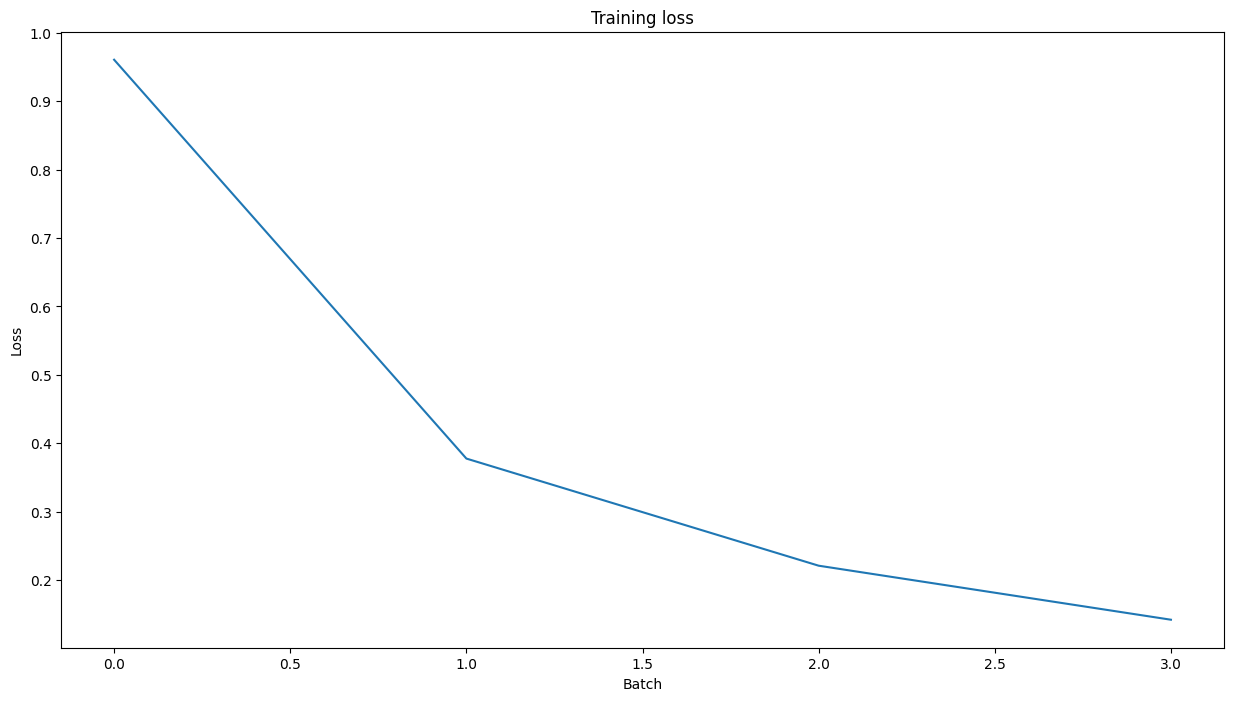

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

### Step 19: Predicting and evaluating using the holdout(testing) dataset

The BERT downstream model was trained with the in_domain_train.tsv dataset.
The program will now make predictions using the holdout (testing) dataset
contained in the out_of_domain_dev.tsv file.

In [ ]:
predictions = []
true_labels = []

# Read the test dataset
df = pd.read_csv("out_of_domain_dev.tsv", delimiter='\t', header=None,
names=['sentence_source', 'label', 'label_notes', 'sentence'])
# Create sentence and label lists
sentences = df.sentence.values
# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

# Predict
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

# Combine the results across all batches.
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Choose the label with the highest score as the predicted label
predictions = np.argmax(predictions, axis=1).flatten()

# Calculate the accuracy
accuracy = np.sum(predictions == true_labels) / len(true_labels)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8259345794392523


### Step 20: Evaluating using Matthews Correlation Coefficient

In [ ]:
from sklearn.metrics import matthews_corrcoef
# Calculate Matthews Correlation Coefficient
mcc = matthews_corrcoef(true_labels, predictions)
print(f"Matthews Correlation Coefficient: {mcc}")

Matthews Correlation Coefficient: 0.5721042539423391
